In [1]:
'''
Author       : Aditya Jain
Date Started : 3rd May, 2021
About        : This is the main training file
'''

'\nAuthor       : Aditya Jain\nDate Started : 3rd May, 2021\nAbout        : This is the main training file\n'

#### Loading Experiment Manager

In [2]:
from comet_ml import Experiment

experiment = Experiment(
    api_key='epeaAhyRcHSkn92H4kusmbX8k',
    project_name='mothai',
    workspace='adityajain07'
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/adityajain07/mothai/c3cd9dc4423549da99a485a5ffcfd742



In [2]:
import torchvision.models as torchmodels
import torch
from torch import nn
from torchsummary import summary
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
import torch.optim as optim
import datetime
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix

from models.resnet50 import Resnet50
from data.mothdataset import MOTHDataset
from training_params.loss import Loss
from training_params.optimizer import Optimizer
from evaluation.micro_accuracy_batch import MicroAccuracyBatch
from evaluation.micro_accuracy_batch import add_batch_microacc, final_microacc
from evaluation.macro_accuracy_batch import MacroAccuracyBatch
from evaluation.macro_accuracy_batch import add_batch_macroacc, final_macroacc, taxon_accuracy
from evaluation.confusion_matrix_data import confusion_matrix_data
from evaluation.confusion_data_conversion import ConfusionDataConvert

In [3]:
config_file   = 'config/01-config.json' #**** This file path should come through command line argument

f             = open(config_file)
config_data   = json.load(f)
print(json.dumps(config_data, indent=3))

image_resize  = config_data['training']['image_resize']
root_dir      = config_data['dataset']['root_dir']
train_set     = config_data['dataset']['train_set']
val_set       = config_data['dataset']['val_set']
test_set      = config_data['dataset']['test_set']
batch_size    = config_data['training']['batch_size']
label_list    = config_data['dataset']['label_info']
epochs        = config_data['training']['epochs']
loss_name     = config_data['training']['loss']['name']
early_stop    = config_data['training']['early_stopping']
start_val_los = config_data['training']['start_val_loss']

label_read    = json.load(open(label_list))
species_list  = label_read['species_list']
genus_list    = label_read['genus_list']
family_list   = label_read['family_list']

no_species_cl = config_data['model']['species_num_classes']
no_genus_cl   = config_data['model']['genus_num_classes']
no_family_cl  = config_data['model']['family_num_classes']

opt_name      = config_data['training']['optimizer']['name']
learning_rate = config_data['training']['optimizer']['learning_rate']
momentum      = config_data['training']['optimizer']['momentum']

mod_save_pth  = config_data['training']['model_save_path']
mod_name      = config_data['training']['model_name']
mod_ver       = config_data['training']['version']
DTSTR         = datetime.datetime.now()
DTSTR         = DTSTR.strftime("%Y-%m-%d-%H-%M")
SAVE_PATH     = mod_save_pth + mod_ver + '_' + mod_name + '_' + DTSTR + '.pt'

taxon_hierar  = config_data['dataset']['taxon_hierarchy']
label_info    = config_data['dataset']['label_info']

api_key       = config_data['exp_management']['api_key']
project_name  = config_data['exp_management']['project_name']
workspace     = config_data['exp_management']['workspace']
tag           = config_data['exp_management']['tag']
# experiment.add_tag(tag)

{
   "note": "This config file is for training on the complete macromoths dataset",
   "model": {
      "species_num_classes": 768,
      "genus_num_classes": 323,
      "family_num_classes": 15,
      "type": "resnet50"
   },
   "dataset": {
      "root_dir": "/miniscratch/transit_datasets/restricted/inat_users/inat/iNat/",
      "train_set": "/home/mila/a/aditya.jain/mothAI/deeplearning/data/01-train_split.csv",
      "val_set": "/home/mila/a/aditya.jain/mothAI/deeplearning/data/01-val_split.csv",
      "test_set": "/home/mila/a/aditya.jain/mothAI/deeplearning/data/01-test_split.csv",
      "label_info": "/home/mila/a/aditya.jain/mothAI/deeplearning/data/numeric_labels.json",
      "taxon_hierarchy": "/home/mila/a/aditya.jain/mothAI/deeplearning/data/taxon_hierarchy.json"
   },
   "training": {
      "batch_size": 64,
      "image_resize": 224,
      "epochs": 20,
      "early_stopping": 4,
      "start_val_loss": 100000000,
      "loss": {
         "name": "crossentropy"
      },
  

#### Loading Model

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Resnet50(config_data).to(device)
# print(model)
print(summary(model, (3,224,224)))  # keras-type model summary

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 

#### Loading Data

In [5]:
# training data loader
train_transformer = transforms.Compose([
                        transforms.Resize((image_resize, image_resize)),              # resize the image to 224x224 
                        transforms.ToTensor()])
train_data        = MOTHDataset(root_dir, train_set, label_list, train_transformer)
train_dataloader  = DataLoader(train_data,batch_size=batch_size, shuffle=True)


# validation data loader
val_transformer   = transforms.Compose([
                        transforms.Resize((image_resize, image_resize)),              # resize the image to 224x224 
                        transforms.ToTensor()])
val_data          = MOTHDataset(root_dir, val_set, label_list, val_transformer)
val_dataloader    = DataLoader(val_data,batch_size=batch_size)

# test data loader
test_transformer  = transforms.Compose([
                        transforms.Resize((image_resize, image_resize)),              # resize the image to 224x224 
                        transforms.ToTensor()])
test_data         = MOTHDataset(root_dir, test_set, label_list, test_transformer)
test_dataloader   = DataLoader(test_data,batch_size=batch_size)

#### Loading Loss function and Optimizer

In [6]:
loss_func = Loss(loss_name).func()
optimizer = Optimizer(opt_name, model, learning_rate, momentum).func()

#### Model Training

In [ ]:
lowest_val_loss = start_val_los
early_stp_count = 0

for epoch in tqdm(range(epochs)):
    train_loss = 0
    val_loss   = 0
    s_time     = time.time()
    
    global_microacc_data_train = None
    global_microacc_data_val   = None
    
    ## model training on training dataset
    model.train()                      # switching model to training mode
    for image_batch, label_batch in train_dataloader:    
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch              = label_batch.squeeze_()          
        
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs   = model(image_batch)        
        t_loss    = loss_func(outputs, label_batch)
        t_loss.backward()
        optimizer.step()        
        train_loss += t_loss.item()
        
        # micro-accuracy calculation
        micro_accuracy_train          = MicroAccuracyBatch(outputs, label_batch, label_info, taxon_hierar).batch_accuracy()   
        global_microacc_data_train    = add_batch_microacc(global_microacc_data_train, micro_accuracy_train)
        
    ## model evaluation on validation dataset
    model.eval()                       # switching model to evaluation mode
    for image_batch, label_batch in val_dataloader:
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch              = label_batch.squeeze_()        
        
        outputs   = model(image_batch)        
        v_loss    = loss_func(outputs, label_batch)
        val_loss += v_loss.item()    
        
        # micro-accuracy calculation
        micro_accuracy_val          = MicroAccuracyBatch(outputs, label_batch, label_info, taxon_hierar).batch_accuracy()   
        global_microacc_data_val    = add_batch_microacc(global_microacc_data_val, micro_accuracy_val)
    
    if val_loss<lowest_val_loss:
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'val_loss':val_loss}, 
#             SAVE_PATH)        
#         experiment.log_model(mod_name, SAVE_PATH)        
        lowest_val_loss = val_loss
        early_stp_count = 0
    else:
        early_stp_count += 1        

    experiment.log_metric("loss_training", train_loss, epoch=epoch)
    experiment.log_metric("loss_validation", val_loss, epoch=epoch)
    
    final_micro_accuracy_train = final_microacc(global_microacc_data_train)
    final_micro_accuracy_val   = final_microacc(global_microacc_data_val)    
    experiment.log_metric("train_micro_species_top1", final_micro_accuracy_train['micro_species_top1'], epoch=epoch)
    experiment.log_metric("train_micro_genus_top1", final_micro_accuracy_train['micro_genus_top1'], epoch=epoch)
    experiment.log_metric("train_micro_family_top1", final_micro_accuracy_train['micro_family_top1'], epoch=epoch)
    experiment.log_metric("val_micro_species_top1", final_micro_accuracy_val['micro_species_top1'], epoch=epoch)
    experiment.log_metric("val_micro_genus_top1", final_micro_accuracy_val['micro_genus_top1'], epoch=epoch)
    experiment.log_metric("val_micro_family_top1", final_micro_accuracy_val['micro_family_top1'], epoch=epoch)    
    
    e_time = (time.time()-s_time)/60   # time taken in minutes    
    experiment.log_metric("time_per_epoch", e_time, epoch=epoch)
    
    if early_stp_count >= early_stop:
        break    

#### Model Evaluation

In [7]:
PATH       = '/home/mila/a/aditya.jain/logs/v01_mothmodel_2021-06-08-04-53.pt'
checkpoint = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load('logs/mothmodel_2021-05-18-07-36.pt', map_location=device))   #**** Wouldn't need this while running this as a script

<All keys matched successfully>

In [8]:
model.eval()                                          # putting the model in evaluation mode
global_microacc_data     = None
global_macroacc_data     = None
global_confusion_data_sp = None
global_confusion_data_g  = None
global_confusion_data_f  = None

print("Prediction on test data started ...")

with torch.no_grad():                                 # switching off gradient computation in evaluation mode
    for image_batch, label_batch in test_dataloader:  
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        predictions              = model(image_batch)
        
        # micro-accuracy calculation
        micro_accuracy           = MicroAccuracyBatch(predictions, label_batch, label_info, taxon_hierar).batch_accuracy()   
        global_microacc_data     = add_batch_microacc(global_microacc_data, micro_accuracy)
        
        # macro-accuracy calculation
        macro_accuracy           = MacroAccuracyBatch(predictions, label_batch, label_info, taxon_hierar).batch_accuracy()
        global_macroacc_data     = add_batch_macroacc(global_macroacc_data, macro_accuracy) 
        
        # confusion matrix
        sp_label_batch, sp_predictions, g_label_batch, g_predictions, f_label_batch, f_predictions = ConfusionDataConvert(predictions, label_batch, label_info, taxon_hierar).converted_data()   
        
        global_confusion_data_sp = confusion_matrix_data(global_confusion_data_sp, [sp_label_batch, sp_predictions])
        global_confusion_data_g  = confusion_matrix_data(global_confusion_data_g, [g_label_batch, g_predictions])
        global_confusion_data_f  = confusion_matrix_data(global_confusion_data_f, [f_label_batch, f_predictions])        
    
        break

Prediction on test data started ...


In [35]:
final_micro_accuracy            = final_microacc(global_microacc_data)
final_macro_accuracy, taxon_acc = final_macroacc(global_macroacc_data)
tax_accuracy                    = taxon_accuracy(taxon_acc, label_read)

In [37]:
# saving evaluation data to file

confdata_pd_f  = pd.DataFrame({'F_Truth': global_confusion_data_f[0].reshape(-1), 'F_Prediction': global_confusion_data_f[1].reshape(-1)})
confdata_pd_g  = pd.DataFrame({'G_Truth': global_confusion_data_g[0].reshape(-1), 'G_Prediction': global_confusion_data_g[1].reshape(-1)})
confdata_pd_sp = pd.DataFrame({'S_Truth': global_confusion_data_sp[0].reshape(-1), 'S_Prediction': global_confusion_data_sp[1].reshape(-1)})
confdata_pd    = pd.concat([confdata_pd_f, confdata_pd_g, confdata_pd_sp], axis=1)

confdata_pd.to_csv(mod_save_pth + mod_ver + '_confusion-data.csv', index=False)

with open(mod_save_pth + mod_ver + '_micro-accuracy.json', 'w') as outfile:
    json.dump(final_micro_accuracy, outfile)

with open(mod_save_pth + mod_ver + '_macro-accuracy.json', 'w') as outfile:
    json.dump(final_macro_accuracy, outfile)
    
with open(mod_save_pth + mod_ver + '_taxon-accuracy.json', 'w') as outfile:
    json.dump(tax_accuracy, outfile)

In [ ]:
experiment.log_metrics(final_micro_accuracy)
experiment.log_metrics(final_macro_accuracy)

experiment.log_parameters(config_data['model'])
experiment.log_parameters(config_data['training'])
experiment.log_parameters(config_data['training']['loss'])
experiment.log_parameters(config_data['training']['optimizer'])

experiment.log_text(tax_accuracy)

experiment.log_others(tax_accuracy)
experiment.log_others(config_data['dataset'])
experiment.log_others(config_data['exp_management'])


label_f = tf.keras.utils.to_categorical(global_confusion_data_f[0], num_classes=no_family_cl)
pred_f  = tf.keras.utils.to_categorical(global_confusion_data_f[1], num_classes=no_family_cl)
experiment.log_confusion_matrix(label_f, pred_f, labels=family_list,
                                max_example_per_cell=100000,
                                title="Family Confusion Matrix")



In [13]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/adityajain07/mothai/ab8c34a2e4614e96a6437bce84be4a32
COMET INFO:   Metrics:
COMET INFO:     macro_family_top1   : 83.91
COMET INFO:     macro_family_top10  : 100.0
COMET INFO:     macro_family_top3   : 91.56
COMET INFO:     macro_genus_top1    : 73.39
COMET INFO:     macro_genus_top10   : 88.89
COMET INFO:     macro_genus_top3    : 84.31
COMET INFO:     macro_species_top1  : 54.44
COMET INFO:     macro_species_top10 : 85.71
COMET INFO:     macro_species_top3  : 77.13
COMET INFO:     micro_family_top1   : 96.79
COMET INFO:     micro_family_top10  : 100.0
COMET INFO:     micro_family_top3   : 99.32
COMET INFO:     micro_genus_top1    : 93.07
COMET INFO:     micro_genus_top10   : 99.66
COMET INFO:     micro_genus_top3    : 98.31
COMET INFO:     micro

## Miscellaneous

In [21]:
from PIL import Image
import pandas as pd

data_list  = pd.read_csv(test_set)

for idx in data_list.index:
    image_data = data_list.iloc[idx, :]
    image_path = root_dir + image_data['family'] + '/' + image_data['genus'] + '/' + image_data['species'] + '/' + image_data['filename']
    image      = Image.open(image_path)
    image      = train_transformer(image)
    
    if image.shape[0]<3:
        print(image_path)
#         plt.imshow(image)
#         break

/miniscratch/adityajain/Cossidae/Prionoxystus/Prionoxystus robiniae/1836625106.jpg


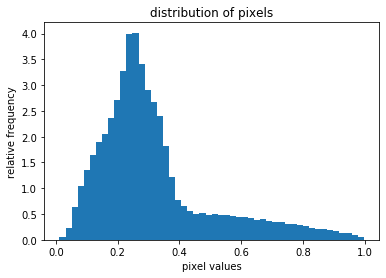

In [7]:
plt.hist(np.array(image_batch[0]).ravel(), bins=50, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

/home/mila/a/aditya.jain/.conda/envs/milamoth/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


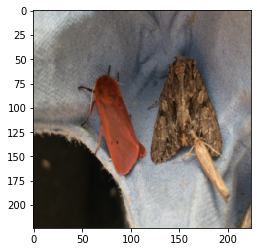

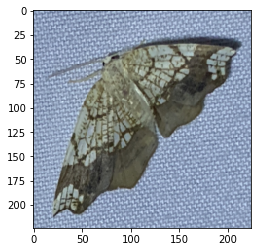

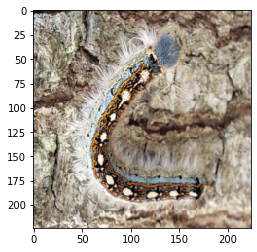

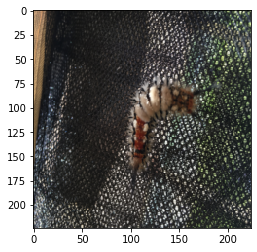

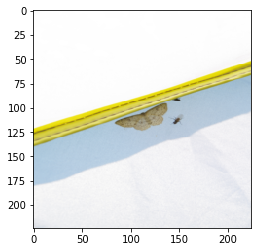

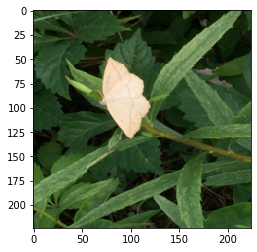

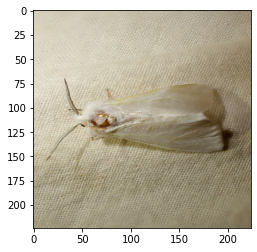

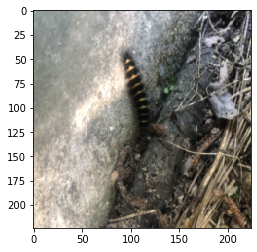

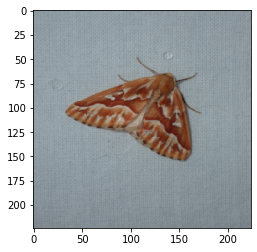

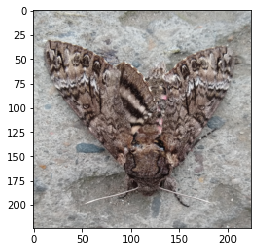

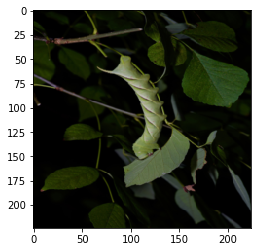

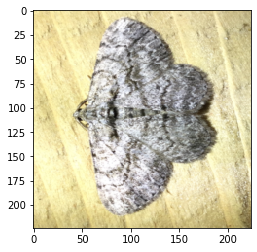

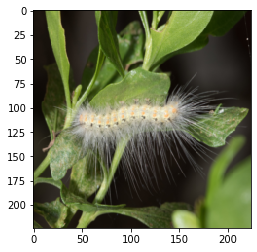

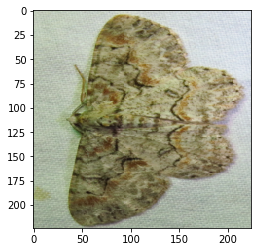

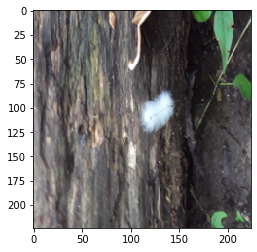

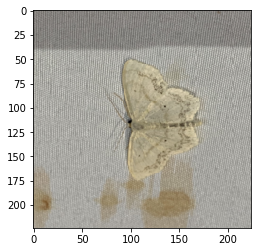

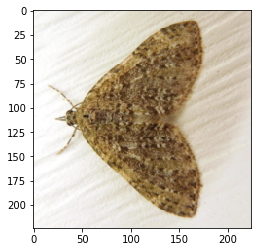

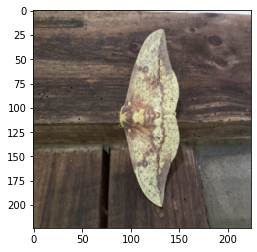

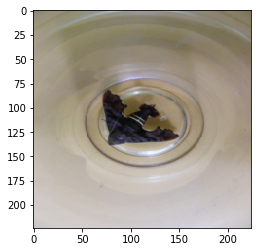

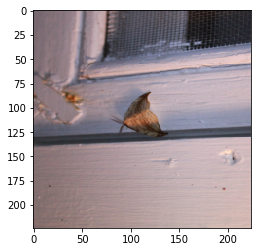

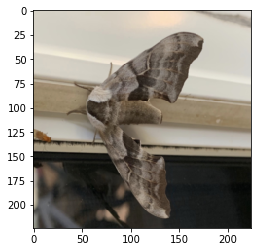

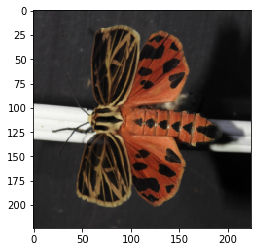

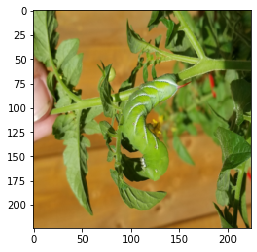

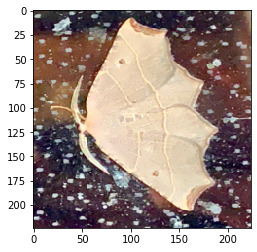

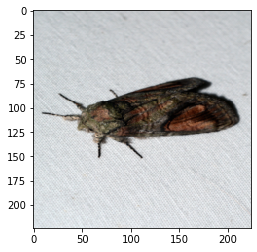

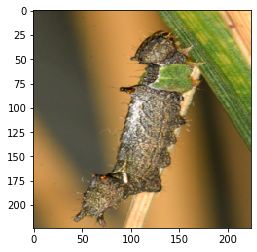

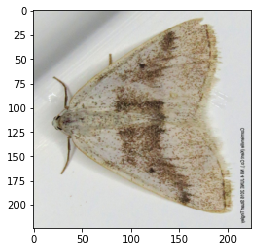

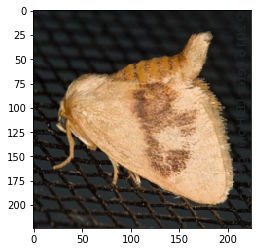

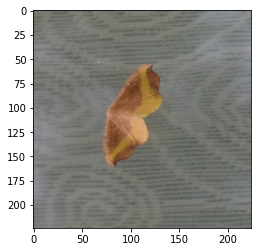

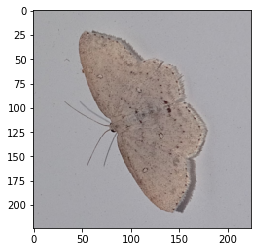

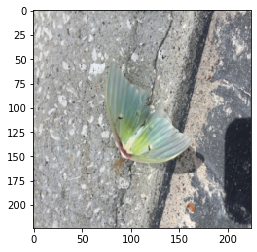

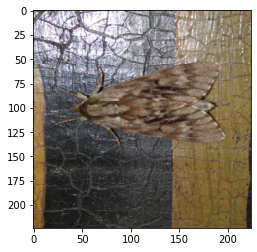

In [7]:
# # for image viewing
# for image in image_batch:
#     plt.figure()
#     plt.imshow(np.transpose(image))

In [8]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

print(input.shape, target.shape)

torch.Size([3, 5]) torch.Size([3])
